# Classification with Random Forest

## Import the libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score, cross_val_predict

## Import and view data

In [4]:
df = pd.read_csv("Train_prepd")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
0,0.0,3.0,22.0,7.2500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,7.9250,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,3.0,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


dims:  (891, 13)


Data have already been preprocessed, as part of the EDA step. Including one-hot encoding and imputation of missing values.

Split into dependent and independent variables.

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 420)

In [7]:
clf_prel = RandomForestClassifier(random_state=420)

In [8]:
clf_prel.fit(X_train, y_train)

RandomForestClassifier(random_state=420)

Accuracy: 84.36 %


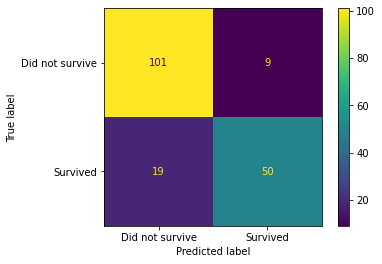

In [10]:
y_pred = clf_prel.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Accuracy: 99.58 %


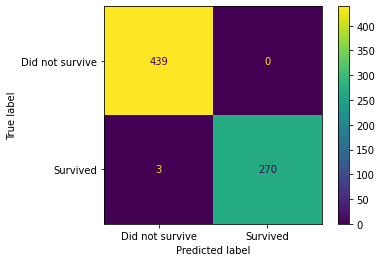

In [12]:
y_pred_tr = clf_prel.predict(X_train)

acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf_prel, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

In [13]:
scores = cross_val_score(clf_prel, X, y, cv=10)
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.2f}'.format(scores.std()))

scores:  [0.8        0.88764045 0.76404494 0.84269663 0.85393258 0.88764045
 0.79775281 0.80898876 0.8988764  0.87640449]
Accuracy: 84.18 %
St.dev: 0.04


## Hyperparameter tuning / Pruning the tree

## Build the final model